# The Airborne Topographic Mapper (ATM) centroid tracker

This notebook illustrates how ATM's centroid tracker for range determination is implemented in Python™. The centroid tracking algorithm has been published in Studinger et al., 2022 (https://doi.org/10.5194/tc-16-3649-2022). A MATLAB® implementation of the `atm_centroid.m` function is available at [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.6341230.svg)](https://doi.org/10.5281/zenodo.6341230)
 

## 1) Centroid of a discrete waveform
The centroid $t_c$ of a discrete waveform $w\,(t_i)$ with amplitudes $w$ digitized at times $t_i$ is defined as

$$
  t_c=\frac{\sum_\limits{t_{start}}^{t_{end}} w\,(t_i) \cdot t_i}{\sum_\limits{t_{start}}^{t_{end}} w\,(t_i)}
$$

where $t_{start}$ and $t_{end}$ are the start and end times of the part of the waveform that is being used for centroid calculation.

## 2) Synthetic Gaussian lidar pulse

In [1]:
# define the parameters of a synthetic Gaussian lidar pulse that is mimicking an ATM lidar pulse, 
# digitized with an 8-bit digitizer with a dynamic range between 0 and 255. 

import math
import numpy as np

# Gaussian pulse parameters
fwhm_ns = 1.3 # full width at half maximum (FWHM) in nanoseconds
b = 5.0         # signal baseline in digitizer counts
a = 250.0       # maximum signal amplitude in digitizer counts
t_m = 10.0      # peak location in nanoseconds
s_g = fwhm_ns/(2*math.sqrt(2*math.log(2))) # 1-sigma pulse width = standard deviation (in nanoseconds)

# set up array of time tags
sampling_rate_ns = 0.25 # digitization interval in nanoseconds
t_s_ns = 0              # start time of synthetic Gaussian pulse in nanoseconds
t_e_ns = 20 + sampling_rate_ns # end time of synthetic Gaussian pulse in nanoseconds
t_i = np.arange(t_s_ns,t_e_ns,sampling_rate_ns)

A discrete Gaussian pulse with amplitude $g$ digitized at times $t_i$ is defined as:

$$
 g(t_i)= b + a \cdot {e ^{-\frac12 \frac{(t_i - t_m)^2}{\sigma^2}}}
$$

where $b$ is the signal baseline (noise floor), $a$ is the maximum pulse amplitude, $t_m$ is pulse location of the pulse maximum and mean, and $\sigma$ is the $1-\sigma$ standard deviation pulse width. For a Gaussian pulse, the mean $t_m$ is identical with the centroid $t_c$, i.e.

$$
 t_c = t_m
$$

To create a synthetic Gaussian lidar pulse that is similar to actual ATM lidar pulses we define some parameters first. The pulse specifications of the newer 1.3 ns ATM lasers are measured in full width at half maximum (FWHM). For a Gaussian pulse the relationship between the FWHM and the standard deviation ($1-sigma$) is:

$$
    FWHM=2 \cdot \sqrt{2 \ln 2} \space \sigma \approx 2.35482 \space \sigma
$$


## 3) The ATM centroid tracker

Real world lidar return signals contain random noise and other instrument artifacts. For practical purposes, the centroid of a pulse is typically calculated from the part of the waveform above a given amplitude threshold. For the ATM centroid tracker the amplitude threshold of the newer 1.3 ns ATM lasers was 15% of the maximum signal amplitude above the baseline. The baseline/noise floor is estimated from the median of the first 21 samples of the waveform.

In [2]:
# calculate amplitudes of a noise-free synthetic Gaussian pulse for demonstration
w_i = b + a*np.exp(-0.5*(t_i - t_m)**2/(s_g)**2) 

In [3]:
# calculating the amplitude threshold using an estimate of the baseline and the maximum signal amplitude
a_perc  = 15.0                                      # percentage of amplitude above baseline for amplitude threshold
bline   = np.median(w_i[:21])                       # baseline/noise floor estimate in digitizer counts
a_thres = (np.max(w_i) - bline)*0.01*a_perc + bline # amplitude threshold for centroid estimate in counts

print(f'selected amplitude percentage: {a_perc:4.1f}%')
print(f'estimated signal baseline [counts]: {bline:3.2f}')
print(f'max signal amplitude above baseline [counts]: {np.max(w_i) - bline:5.1f}')
print(f'amplitude threshold for centroid [counts]: {a_thres:4.1f}')

selected amplitude percentage: 15.0%
estimated signal baseline [counts]: 5.00
max signal amplitude above baseline [counts]: 250.0
amplitude threshold for centroid [counts]: 42.5


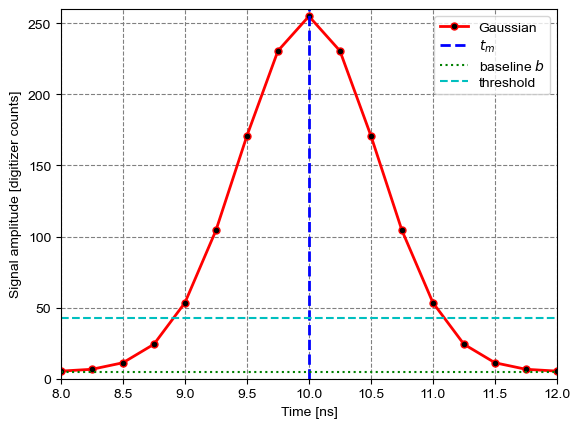

In [4]:
import matplotlib.pyplot as plt

fig, (ax) = plt.subplots(1, 1)
ax.plot(t_i,w_i, markersize = 5,color = 'red', lw = 2, label='Gaussian',marker='o',linestyle='-', markerfacecolor = 'k')
ax.axvline(t_m, color='b', linestyle='--', linewidth=2, label='$t_{m}$')
ax.axhline(b, color='g', linestyle=':', linewidth=1.5, label='baseline $b$')
ax.axhline(a_thres, color='c', linestyle='--', linewidth=1.5, label='threshold')

ax.set_xlabel("Time [ns]")
ax.set_ylabel(r"Signal amplitude [digitizer counts]")
ax.grid(True)
ax.grid(color='gray', linestyle='--', linewidth=0.80)
#ax.set(xlim = (min(t_i), max(t_i)))
ax.set(xlim = (8.0, 12.0))

ax.set(ylim = (0, 260))
h = ax.legend(loc='upper right', labelspacing = 0.25)

## 4) Python™ implementation of the ATM centroid tracker
This demonstration of the ATM centroid tracker uses an actual ATM return signal waveform, acquired with ATM's 532 nm T7 laser over the Greenland Ice Sheet on May 15, 2019.

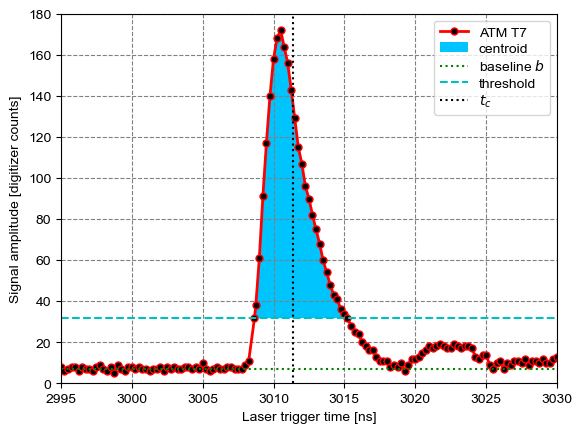

In [5]:
# import ATM waveform
t = np.loadtxt('atm_wvfm.csv', delimiter=',', usecols=(0), unpack=True, skiprows=4)
w = np.loadtxt('atm_wvfm.csv', delimiter=',', usecols=(1), unpack=True, skiprows=4)

# estimate baseline and calculate amplitude threshold at desired maximum amplitude percentage
bline = np.median(w[:21])                         # baseline/noise floor estimate in digitizer counts
a_thres = (np.max(w) - bline)*0.01*a_perc + bline # amplitude threshold for centroid estimate in counts
# first, determine the index of the sample with the maximum amplitude
indx_max = np.where(w == w.max())[0][0]
# now, find the last sample from the beginning that is below the amplitude threshold
indx_left = np.where(w[:indx_max] <= a_thres)[0][-1] # returns the last sample
# next, find the last sample after the maximum that is above the amplitude threshold
indx_right = np.where(w[indx_max:-1] >= a_thres)[0][-1] # returns the last sample
indx_right = indx_right + indx_max + 1 # this is the first sample in the trailing edge that's below the amplitude threshoold 

# do a linear interpolation around the first and last sample to estimate the entire curve 
# above the specified amplitude threshold
t_above = t[indx_left:indx_right+1]
w_above = w[indx_left:indx_right+1]
t_s = (((t_above[1]-t_above[0])/(w_above[1]-w_above[0])) * (a_thres - w_above[0]) ) + t_above[0]
t_e = (((t_above[-1]-t_above[-2])/(w_above[-1]-w_above[-2])) * (a_thres - w_above[-2]) ) + t_above[-2]
# now replace first and last elements in t_above and w_above:
t_above[0] = t_s
w_above[0] = a_thres
t_above[-1] = t_e
w_above[-1] = a_thres

# use trapezoidal method to determine the approximate integral 
upper = np.trapz(w_above*t_above,t_above)
lower = np.trapz(w_above,t_above)
t_c = upper/lower # centroid

# plot waveform data, samples above the amplitude threshold, and centroid estimate
fig, (ax) = plt.subplots(1, 1)
ax.plot(t,w, markersize = 5,color = 'red', lw = 2, label='ATM T7',marker='o',linestyle='-', markerfacecolor = 'k')
ax.fill(t_above, w_above,facecolor=(0,0.76953125,0.99609375), edgecolor='none', linewidth=0.1,label='centroid')
ax.axhline(bline, color='g', linestyle=':', linewidth=1.5, label='baseline $b$')
ax.axhline(a_thres, color='c', linestyle='--', linewidth=1.5, label='threshold')
ax.axvline(t_c, color='k', linestyle=':', linewidth=1.5, label='$t_{c}$')
ax.set_xlabel("Laser trigger time [ns]")
ax.set_ylabel(r"Signal amplitude [digitizer counts]")
ax.grid(True)
ax.grid(color='gray', linestyle='--', linewidth=0.80)
ax.set(ylim = (0, 180))
ax.set(xlim = (2995, 3030))
h = ax.legend(loc='upper right', labelspacing = 0.25)

## 5) Comparison of Python™ code with MATLAB® function

The time difference $\Delta$t between $t_c(Python)$ estimated with Python™ and $t_c(MATLAB®)$ calculated using the MATLAB® function is:  

In [6]:
# import centroid estimate from MATLAB® function
tmp_matlab = open('atm_wvfm_centroid_matlab.csv', 'r')
lreader = tmp_matlab.readlines()
t_c_matlab = float(lreader[3][23:-1])
print(f'Δt(Python™ - 𝑀𝐴𝑇𝐿𝐴𝐵®) [ns]: {t_c - t_c_matlab:37.35f}')

Δt(Python™ - 𝑀𝐴𝑇𝐿𝐴𝐵®) [ns]: 0.00000000000000000000000000000000000


The centroid estimates from the Python™ and 𝑀𝐴𝑇𝐿𝐴𝐵® implementations are identical within the computational noise and can therefore be neglected. 